# Comparing NN-receiver performance against ZF/LS receiver performance on testset

In [1]:
from config import *
import torch
from torch.utils.data import DataLoader
from models_local import *
from OFDM_SDR_Functions_torch_v2 import *
#from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
# Display the selected device
print(device)

device = "cpu" # Force CPU for now, trouble with converting complex tensors to mps

save_plots = False

mps


## Load the testset

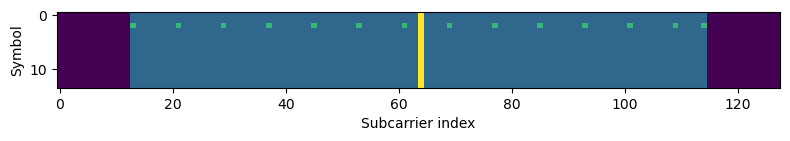

14 102 8 2 13
822 1400 5600 4
14 1400 14


In [ ]:
TTI_mask_RE = OFDM_block_mask(S=S,F=F, Fp=Fp, Sp=Sp, FFT_offset=FFT_offset, plotOFDM_block=True).to(device) # TTI mask
print(S, F, Fp, Sp, FFT_offset)
pilot_symbols = pilot_set(TTI_mask_RE, 1).to(device) # pilot symbols

mapping_table_QPSK, de_mapping_table_QPSK = mapping_table(2) # mapping table QPSK (e.g. for pilot symbols)
mapping_table_Qm, de_mapping_table_Qm = mapping_table(Qm, plot=False) # mapping table for Qm

# load the testset
# test_set = torch.load('data/ofdm_testset_4_8_aalto.pth', weights_only=False) # Aalto
test_set = torch.load('data/ofdm_testset_4_8_sdr.pth', weights_only=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

for sample in test_loader:
    pdsch_iq, labels, sinr = sample
    break 
n_iterations = int(len(test_loader))
n_symbols = int(len(labels.squeeze()))
n_bits_per_iteration = int(len(labels.flatten()))
#mean_SINR = torch.mean(sinr)
Qm = int(n_bits_per_iteration / n_symbols)
print(n_iterations, n_symbols, n_bits_per_iteration, Qm)
print(TTI_mask_RE[TTI_mask_RE == 2].numel(), TTI_mask_RE[TTI_mask_RE == 1].numel(), TTI_mask_RE[TTI_mask_RE == 3].numel())

In [22]:
pdsch_iq, labels, sinr = test_set[1]
pdsch_iq[1,60:70]

tensor([ 0.0128-0.0417j, -0.7916+0.2226j, -0.3336-0.6143j,  0.6260+0.2443j,
        -0.1987-0.1240j, -0.7487-0.3559j, -0.4685+0.2420j, -0.2119-0.0047j,
         0.0870+0.0695j,  0.4315+0.4035j])

## Load the model and weights

In [29]:
model = RXModel_2(Qm).to(device)
checkpoint_path = 'data/models/rx_model_4_8_148.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Run the testset and measure BER with both receivers

In [30]:
#plt.imshow(TTI_mask_RE)

TTI_mask_RE = extract_middle_subcarriers(TTI_mask_RE, FFT_size_RX) # 14,128
TTI_mask_RE_3d = TTI_mask_RE.unsqueeze(-1).expand(S, FFT_size_RX, Qm) # 14, 128, 4

def labels4d23d(batch_size, labels):
    TTI_mask_indices = torch.where(TTI_mask_RE==1) # 1387
    TTI_3d = torch.zeros((batch_size, TTI_mask_RE.shape[0], TTI_mask_RE.shape[1], 4)).to(device)
    row_indices, col_indices = TTI_mask_indices
    # print the 
    row_indices.to(device)
    col_indices.to(device)
    TTI_3d[:, row_indices, col_indices, :] = labels.clone().detach().to(device)
    return TTI_3d

# Evaluate the model on the test set
test_losses_NN = []
test_BERs_NN = []
test_BERs_ZFLS = []

wrongs_nn=[]
wrongs_ls=[]
sinrs = []
n_ofdm_blocks = 0
with torch.no_grad():
    for test_pdsch_iq, test_labels, sinr in test_loader:
        n_ofdm_blocks += 1
        # NN receiver ###################################################
        test_labels, sinr = test_labels.float().to(device), sinr.float().to(device)
        # test labels 1400,1
        test_pdsch_iq_real = test_pdsch_iq.real.float()
        test_pdsch_iq_imag = test_pdsch_iq.imag.float()
        test_pdsch_iq_nn = torch.stack([test_pdsch_iq_real, test_pdsch_iq_imag], dim=1).to(device)
        test_outputs = model((test_pdsch_iq_nn.to(device)))
        binary_predictions = test_outputs.squeeze()[TTI_mask_RE_3d==1]
        binary_predictions = torch.round(binary_predictions)

        # BER for NN
        test_labels = labels4d23d(1, test_labels)
        test_labels = test_labels.squeeze()[TTI_mask_RE_3d==1]
        test_pdsch_iq, test_labels = test_pdsch_iq.squeeze().to(device), test_labels.squeeze().to(device)
        error_count = torch.sum(binary_predictions != test_labels).float()  # Count of unequal bits
        new_wrongs_nn = (binary_predictions.flatten() != test_labels.flatten()).float().tolist()
        wrongs_nn.append(new_wrongs_nn)
        error_rate = error_count / len(test_labels.flatten())  # Error rate calculation
        BER_NN = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places
        test_BERs_NN.append(BER_NN.item())

        # ZF-LS receiver ####################################################
        test_pdsch_iq_w = test_pdsch_iq
        H_estim = channelEstimate_LS(TTI_mask_RE, pilot_symbols, F, FFT_offset_RX, Sp, test_pdsch_iq_w, plotEst=False) # calculate channel estimate
        test_pdsch_iq_w = remove_fft_Offests(test_pdsch_iq_w, F, FFT_offset_RX) # remove FFT offsets
        equalized_H_estim = equalize_ZF(test_pdsch_iq_w, H_estim, F, S) # equalize the received signal
        QAM_est = get_payload_symbols(TTI_mask_RE, equalized_H_estim, FFT_offset_RX, F) # get the payload symbols 
        PS_est, hardDecision = Demapping(QAM_est, de_mapping_table_Qm) # demap the symbols
        bits_est = torch.tensor(PS(PS_est).flatten().cpu(), dtype=torch.int8) # convert to bits

        # Calculate Bit Error Rate (BER) for the ZF-LS receiver
        test_labels = torch.tensor(test_labels.flatten().cpu(), dtype=torch.int8)
        new_wrongs_ls = (bits_est != test_labels).float().tolist()
        wrongs_ls.append(new_wrongs_ls)
        error_count = torch.sum(bits_est != test_labels).float()  # Count of unequal bits
        error_rate = error_count / bits_est.numel()  # Error rate calculation
        BER_ZFLS = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places
        test_BERs_ZFLS.append(BER_ZFLS.item())
      
        # add the SINR
        sinrs.append(sinr.to('cpu').numpy())


/var/folders/8d/3ktk5sxn64316lz6dtjghw640000gn/T/ipykernel_25440/4147101357.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bits_est = torch.tensor(PS(PS_est).flatten().cpu(), dtype=torch.int8) # convert to bits
/var/folders/8d/3ktk5sxn64316lz6dtjghw640000gn/T/ipykernel_25440/4147101357.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels.flatten().cpu(), dtype=torch.int8)


## Observe if there are time domain problems, either in the NN, or in the LS receiver

### NN-receiver, cumulative errors per bit in payload

Text(0.5, 1.0, 'DeepRx')

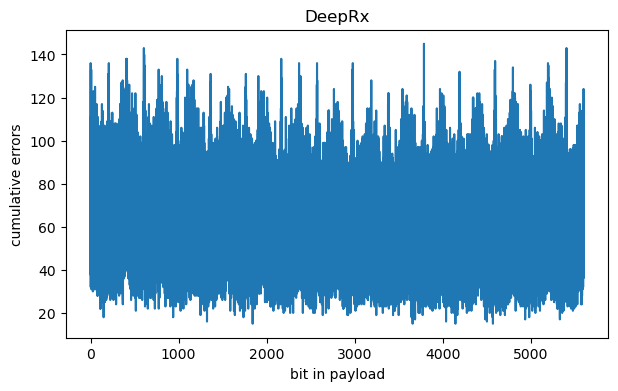

In [31]:
# NN receiver
fig = plt.figure(figsize=(7,4))
plt.plot(np.sum(wrongs_nn, axis=0))
plt.xlabel('bit in payload')
plt.ylabel('cumulative errors')
plt.title('DeepRx')

In [32]:
print(n_ofdm_blocks)
print(np.sum(np.sum(wrongs_nn, axis=0))/n_bits_per_iteration/n_iterations)
print(len(wrongs_nn))

822
0.07806830031282586
822


### LS/ZF-receiver, cumulative errors per symbol in OFDM block

a (822, 5600)
b (5600,)
c 1400


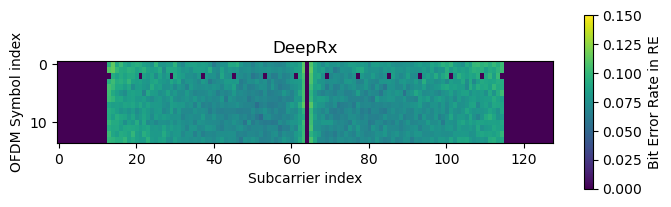

In [48]:
# Create a zero tensor for the overall F subcarriers * S symbols
TTI_t = np.zeros(TTI_mask_RE.shape)
wrongs_nn_x = np.array(wrongs_nn).astype(int)
print('a',wrongs_nn_x.shape) # 1462, 1387
wrongs_nn_x=wrongs_nn_x.sum(axis=0)
print('b',wrongs_nn_x.shape) # 1387
wrongs_nn_x=wrongs_nn_x.reshape([n_symbols,Qm]).sum(axis=1)#1462

print('c',n_symbols)
# Allocate the payload and pilot
plt.figure(figsize=(plot_width, 1.5))
TTI_t[TTI_mask_RE==1] = wrongs_nn_x/n_iterations/Qm
plt.imshow(TTI_t, interpolation='nearest', aspect=1.5, vmax=0.15)
plt.colorbar(label='Bit Error Rate in RE', shrink=1.5)

plt.xlabel('Subcarrier index')
plt.ylabel('OFDM Symbol index')
plt.title('DeepRx')
if save_plots:
    plt.savefig(f'pics/bit_errors_in_block_nn_{Qm}_{Fp}.png', bbox_inches='tight')

/Users/riku/projects_mac/ofdm-plutosdr-pytorch/.conda/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/riku/projects_mac/ofdm-plutosdr-pytorch/.conda/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/8d/3ktk5sxn64316lz6dtjghw640000gn/T/ipykernel_25440/780261281.py:20: RuntimeWarning: Mean of empty slice
  mean_ber_per_distance_subcarrier[idx] = np.nanmean(ber_per_subcarrier[distance_from_pilot_subcarrier == dist])


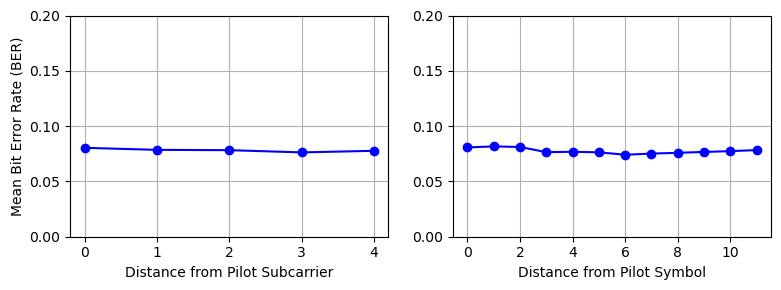

In [34]:
# Identify pilot subcarriers and symbols
pilot_subcarrier_indices = np.where(TTI_mask_RE == 2)[1]
pilot_symbol_indices = np.where(TTI_mask_RE == 2)[0]

# Calculate the distance from each subcarrier to the nearest pilot subcarrier
distance_from_pilot_subcarrier = np.zeros(TTI_mask_RE.shape[1])
for i in range(TTI_mask_RE.shape[1]):
    distance_from_pilot_subcarrier[i] = np.min(np.abs(pilot_subcarrier_indices - i))

# Calculate BER for each subcarrier
ber_per_subcarrier = np.zeros(TTI_mask_RE.shape[1])
for i in range(TTI_mask_RE.shape[1]):
    ber_per_subcarrier[i] = np.mean(TTI_t[:, i][TTI_mask_RE[:, i] == 1])

# Calculate mean BER for each distance from pilot subcarrier
unique_distances_subcarrier = np.unique(distance_from_pilot_subcarrier)
mean_ber_per_distance_subcarrier = np.zeros_like(unique_distances_subcarrier, dtype=float)

for idx, dist in enumerate(unique_distances_subcarrier):
    mean_ber_per_distance_subcarrier[idx] = np.nanmean(ber_per_subcarrier[distance_from_pilot_subcarrier == dist])

# Calculate the distance from each OFDM symbol to the nearest pilot symbol
distance_from_pilot_symbol = np.zeros(TTI_mask_RE.shape[0])
for i in range(TTI_mask_RE.shape[0]):
    distance_from_pilot_symbol[i] = np.min(np.abs(pilot_symbol_indices - i))

# Calculate BER for each OFDM symbol
ber_per_symbol = np.zeros(TTI_mask_RE.shape[0])
for i in range(TTI_mask_RE.shape[0]):
    ber_per_symbol[i] = np.mean(TTI_t[i, :][TTI_mask_RE[i, :] == 1])

# Calculate mean BER for each distance from pilot symbol
unique_distances_symbol = np.unique(distance_from_pilot_symbol)
mean_ber_per_distance_symbol = np.zeros_like(unique_distances_symbol, dtype=float)

for idx, dist in enumerate(unique_distances_symbol):
    mean_ber_per_distance_symbol[idx] = np.nanmean(ber_per_symbol[distance_from_pilot_symbol == dist])

# Determine the same scale for both plots
max_distance = max(max(unique_distances_subcarrier), max(unique_distances_symbol))
max_ber = max(np.nanmax(mean_ber_per_distance_subcarrier), np.nanmax(mean_ber_per_distance_symbol))


# Create a single subplot with two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(plot_width, 3))

# Plot Mean BER vs Distance from Pilot Subcarrier
ax1.plot(unique_distances_subcarrier, mean_ber_per_distance_subcarrier, 'bo-')
ax1.set_xlabel('Distance from Pilot Subcarrier')
ax1.set_ylabel('Mean Bit Error Rate (BER)')

ax1.grid(True)
#ax1.set_ylim(0.0, max_ber*1.1)
ax1.set_ylim(0.0, 0.2)

# Plot Mean BER vs Distance from Pilot Symbol
ax2.plot(unique_distances_symbol, mean_ber_per_distance_symbol, 'bo-')
ax2.set_xlabel('Distance from Pilot Symbol')

ax2.grid(True)
#ax2.set_ylim(0.015, max_ber*1.1)
ax2.set_ylim(0, 0.2)

plt.tight_layout()

if save_plots:
    plt.savefig('pics/mean_ber_vs_distance_from_pilot_combined_nn.png', bbox_inches='tight')

plt.show()

In [35]:
ber_with_pilots = []
ber_without_pilots = []

for i in range(TTI_mask_RE.shape[1]):
    is_modulated = np.any(TTI_mask_RE.numpy()[:, i] != 0) and np.any (TTI_mask_RE.numpy()[:, i] != 3) # check not fft offset, or dc
    if is_modulated:
        has_pilots = np.any(TTI_mask_RE.numpy()[:, i] == 2)  # Check if pilots are present in this symbol index
        if has_pilots:
            ber_with_pilots.append(np.mean(TTI_t[:,i]) )
        else:
            ber_without_pilots.append(np.mean(TTI_t[:,i]))

print(f'Subcarriers with pilots BER {np.mean(ber_with_pilots)},  without pilots BER {np.mean(ber_without_pilots)}')

Subcarriers with pilots BER 0.07463751924127317,  without pilots BER 0.0777230432402846


Subcarriers with pilots BER [np.float64(0.08388439208884393), np.float64(0.0835591770855918), np.float64(0.08071146908297676), np.float64(0.07977102454771025), np.float64(0.07835874828358748), np.float64(0.07644359326443592), np.float64(0.07680795451807954), np.float64(0.07630206451302064), np.float64(0.0741038519910385), np.float64(0.07516080075160801), np.float64(0.0758594107585941), np.float64(0.07666341451663415), np.float64(0.07736804702368047), np.float64(0.07832863578328636)]


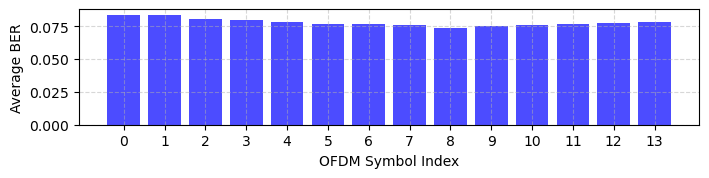

In [36]:
ber_ofdm_symbol = []

for i in range(TTI_mask_RE.shape[0]):
            row_values = TTI_t[i]
            ber_ofdm_symbol.append(np.mean(row_values[row_values != 0]) )


print(f'Subcarriers with pilots BER {ber_ofdm_symbol}')

# Plotting the bar chart
plt.figure(figsize=(plot_width, 1.5))
plt.bar(np.arange(len(ber_ofdm_symbol)), ber_ofdm_symbol, color='b', alpha=0.7)
plt.xlabel('OFDM Symbol Index')
plt.ylabel('Average BER')
plt.xticks(np.arange(len(ber_ofdm_symbol)), np.arange(len(ber_ofdm_symbol)))
plt.grid(True, linestyle='--', alpha=0.5)
#plt.ylim(0.04,0.055)
plt.show()
if save_plots:
    plt.savefig(f'pics/ber_per_ofdm_symbols_NN_{Qm}_{Fp}.png', bbox_inches='tight')

### LS/ZF-receiver, cumulative errors per bit in payload

Text(0, 0.5, 'cumulative errors')

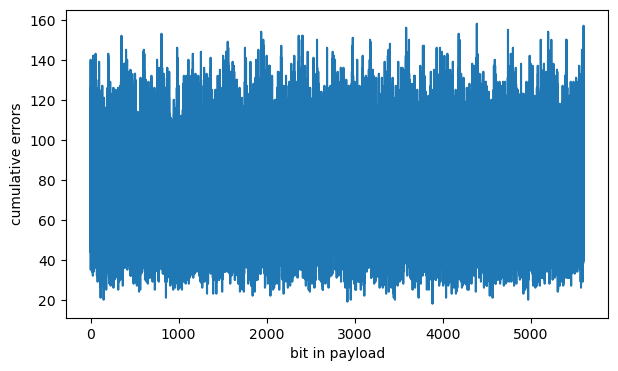

In [37]:
#LS/ZF receiver
fig = plt.figure(figsize=(7,4))
plt.plot(np.sum(wrongs_ls, axis=0))
plt.xlabel('bit in payload')
plt.ylabel('cumulative errors')

### LS/ZF-receiver, cumulative errors per symbol in OFDM block

In [38]:
n_ofdm_blocks

822

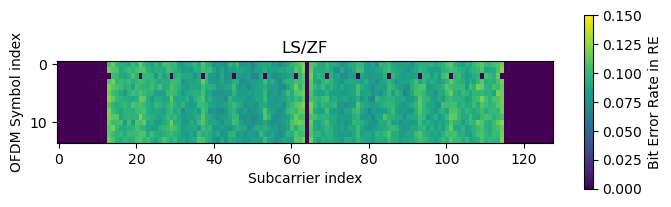

In [47]:
# Create a zero tensor for the overall F subcarriers * S symbols
TTI_t = np.zeros(TTI_mask_RE.shape)
wrongs_ls_x = np.array(wrongs_ls).astype(int)
wrongs_ls_x=wrongs_ls_x.sum(axis=0)
wrongs_ls_x=wrongs_ls_x.reshape([n_symbols,Qm]).sum(axis=1)#1462

# Allocate the payload and pilot
plt.figure(figsize=(plot_width, 1.5))
TTI_t[TTI_mask_RE==1] = wrongs_ls_x/4/n_ofdm_blocks
plt.imshow(TTI_t, interpolation='nearest', aspect=1.5, vmax=0.15)
plt.colorbar(label='Bit Error Rate in RE', shrink=1.5)

plt.xlabel('Subcarrier index')
plt.ylabel('OFDM Symbol index')
plt.title('LS/ZF')

if save_plots:
    plt.savefig(f'pics/bit_errors_in_block_ZF_{Qm}_{Fp}.png', bbox_inches='tight')

/Users/riku/projects_mac/ofdm-plutosdr-pytorch/.conda/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/riku/projects_mac/ofdm-plutosdr-pytorch/.conda/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/8d/3ktk5sxn64316lz6dtjghw640000gn/T/ipykernel_25440/2484360602.py:20: RuntimeWarning: Mean of empty slice
  mean_ber_per_distance_subcarrier[idx] = np.nanmean(ber_per_subcarrier[distance_from_pilot_subcarrier == dist])


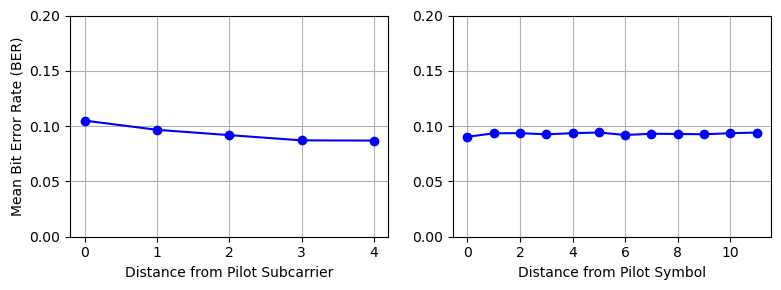

In [40]:
# Identify pilot subcarriers and symbols
pilot_subcarrier_indices = np.where(TTI_mask_RE == 2)[1]
pilot_symbol_indices = np.where(TTI_mask_RE == 2)[0]

# Calculate the distance from each subcarrier to the nearest pilot subcarrier
distance_from_pilot_subcarrier = np.zeros(TTI_mask_RE.shape[1])
for i in range(TTI_mask_RE.shape[1]):
    distance_from_pilot_subcarrier[i] = np.min(np.abs(pilot_subcarrier_indices - i))

# Calculate BER for each subcarrier
ber_per_subcarrier = np.zeros(TTI_mask_RE.shape[1])
for i in range(TTI_mask_RE.shape[1]):
    ber_per_subcarrier[i] = np.mean(TTI_t[:, i][TTI_mask_RE[:, i] == 1])

# Calculate mean BER for each distance from pilot subcarrier
unique_distances_subcarrier = np.unique(distance_from_pilot_subcarrier)
mean_ber_per_distance_subcarrier = np.zeros_like(unique_distances_subcarrier, dtype=float)

for idx, dist in enumerate(unique_distances_subcarrier):
    mean_ber_per_distance_subcarrier[idx] = np.nanmean(ber_per_subcarrier[distance_from_pilot_subcarrier == dist])

# Calculate the distance from each OFDM symbol to the nearest pilot symbol
distance_from_pilot_symbol = np.zeros(TTI_mask_RE.shape[0])
for i in range(TTI_mask_RE.shape[0]):
    distance_from_pilot_symbol[i] = np.min(np.abs(pilot_symbol_indices - i))

# Calculate BER for each OFDM symbol
ber_per_symbol = np.zeros(TTI_mask_RE.shape[0])
for i in range(TTI_mask_RE.shape[0]):
    ber_per_symbol[i] = np.mean(TTI_t[i, :][TTI_mask_RE[i, :] == 1])

# Calculate mean BER for each distance from pilot symbol
unique_distances_symbol = np.unique(distance_from_pilot_symbol)
mean_ber_per_distance_symbol = np.zeros_like(unique_distances_symbol, dtype=float)

for idx, dist in enumerate(unique_distances_symbol):
    mean_ber_per_distance_symbol[idx] = np.nanmean(ber_per_symbol[distance_from_pilot_symbol == dist])

# Determine the same scale for both plots
max_distance = max(max(unique_distances_subcarrier), max(unique_distances_symbol))
max_ber = max(np.nanmax(mean_ber_per_distance_subcarrier), np.nanmax(mean_ber_per_distance_symbol))


# Create a single subplot with two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(plot_width, 3))

# Plot Mean BER vs Distance from Pilot Subcarrier
ax1.plot(unique_distances_subcarrier, mean_ber_per_distance_subcarrier, 'bo-')
ax1.set_xlabel('Distance from Pilot Subcarrier')
ax1.set_ylabel('Mean Bit Error Rate (BER)')

ax1.grid(True)
#ax1.set_ylim(0.0, max_ber*1.1)
ax1.set_ylim(0.0, 0.2)

# Plot Mean BER vs Distance from Pilot Symbol
ax2.plot(unique_distances_symbol, mean_ber_per_distance_symbol, 'bo-')
ax2.set_xlabel('Distance from Pilot Symbol')

ax2.grid(True)
#ax2.set_ylim(0.0, max_ber*1.1)
ax2.set_ylim(0.0, 0.2)


plt.tight_layout()

if save_plots:
    plt.savefig('pics/mean_ber_vs_distance_from_pilot_combined_ls.png', bbox_inches='tight')

plt.show()

In [41]:
ber_with_pilots = []
ber_without_pilots = []

for i in range(TTI_mask_RE.shape[1]):
    is_modulated = np.any(TTI_mask_RE.numpy()[:, i] != 0) and np.any (TTI_mask_RE.numpy()[:, i] != 3) # check not fft offset, or dc
    if is_modulated:
        has_pilots = np.any(TTI_mask_RE.numpy()[:, i] == 2)  # Check if pilots are present in this symbol index
        if has_pilots:
            ber_with_pilots.append(np.mean(TTI_t[:,i]) )
        else:
            ber_without_pilots.append(np.mean(TTI_t[:,i]))

print(f'Subcarriers with pilots BER {np.mean(ber_with_pilots)},  without pilots BER {np.mean(ber_without_pilots)}')

Subcarriers with pilots BER 0.09748032424648691,  without pilots BER 0.09135424032856702


## Calculate the mean BER, illustrate BER distribution

In [42]:
# Calculate average test loss and BER
average_test_BER_NN = sum(test_BERs_NN) / len(test_BERs_NN)
average_test_BER_ZFLS = sum(test_BERs_ZFLS) / len(test_BERs_ZFLS)

# Print or log average test loss and BER for both the NN and ZF-LS receiver
print('Average test BER NN: {:.4f}'.format(average_test_BER_NN))
print('Average test BER ZF-LS: {:.4f}'.format(average_test_BER_ZFLS))

Average test BER NN: 0.0781
Average test BER ZF-LS: 0.0931


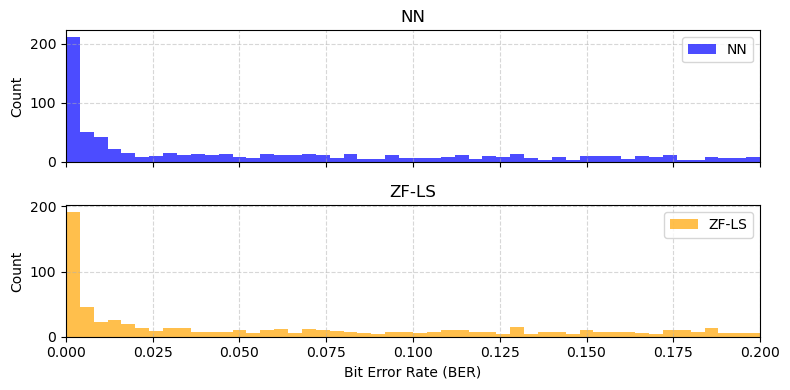

In [43]:
bins = np.linspace(0, 0.2, 51)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(plot_width, 4), sharex=True)

# Plotting with logarithmic scale for y-axis
ax1.hist(test_BERs_NN, bins=bins, alpha=0.7, color='blue', label='NN')
ax1.set_ylabel('Count')
ax1.set_title('NN')
ax1.legend()
ax1.set_xlim(0, 0.2)
ax1.grid(True, linestyle='--', alpha=0.5)

ax2.hist(test_BERs_ZFLS, bins=bins, alpha=0.7, color='orange', label='ZF-LS')
ax2.set_xlabel('Bit Error Rate (BER)')
ax2.set_ylabel('Count')
ax2.set_title('ZF-LS')
ax2.legend()
ax2.set_xlim(0, 0.2)
ax2.grid(True, linestyle='--', alpha=0.5)

# Adjust layout and save plot if needed
plt.tight_layout()
if save_plots:
    plt.savefig(f'pics/BER_distribution_testset_subplots_{Qm}_{Fp}.png', bbox_inches='tight')

plt.show()

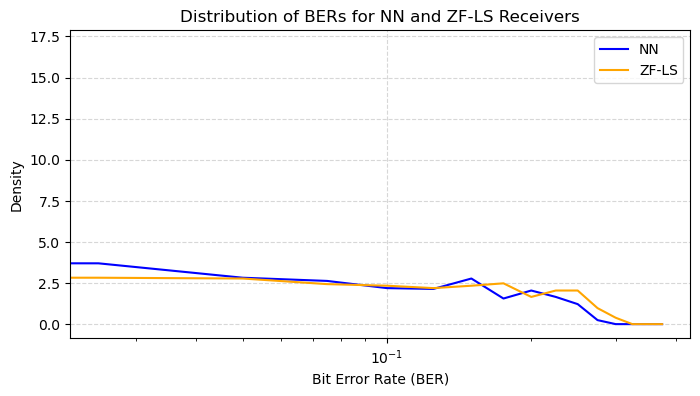

In [44]:

# Assuming test_BERs_NN and test_BERs_ZFLS are your data arrays

bins = np.linspace(0, 0.4, 17)

# Calculate histograms for NN and ZF-LS BERs
hist_NN, _ = np.histogram(test_BERs_NN, bins=bins, density=True)
hist_ZFLS, _ = np.histogram(test_BERs_ZFLS, bins=bins, density=True)

# Plotting with logarithmic scale for y-axis
plt.figure(figsize=(8, 4))

# Plot curves for NN and ZF-LS BERs
plt.plot(bins[:-1], hist_NN, color='blue', label='NN')
plt.plot(bins[:-1], hist_ZFLS, color='orange', label='ZF-LS')

plt.xlabel('Bit Error Rate (BER)')
plt.ylabel('Density')
plt.title('Distribution of BERs for NN and ZF-LS Receivers')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xscale('log')
if save_plots:
    plt.savefig(f'pics/BER_distribution_testset_curves.png', bbox_inches='tight')

plt.show()

## BER vs. SINR

/var/folders/8d/3ktk5sxn64316lz6dtjghw640000gn/T/ipykernel_25440/1043333075.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_no_outliers = df.groupby('SINR_binned').apply(process_group).reset_index(drop=True)
/var/folders/8d/3ktk5sxn64316lz6dtjghw640000gn/T/ipykernel_25440/1043333075.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_no_outliers = df.groupby('SINR_binned').apply(process_group).reset_index(drop=True)
/var/folders/8d/3ktk5sxn64316lz6dtjghw640000gn/T/ipykernel_25440/1043333075.py:34

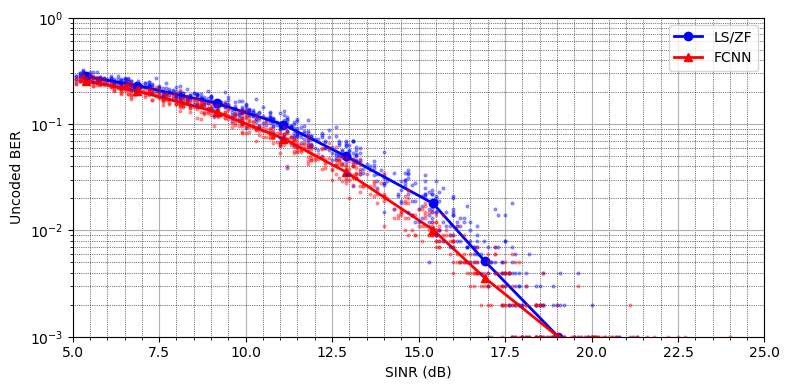

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import re

save_plots = True
df = pd.DataFrame({
    'BER_NN': np.squeeze(test_BERs_NN),
    'BER_LSZF': np.squeeze(test_BERs_ZFLS),
    'SINR': np.squeeze(sinrs)
})

# Bin the SINR values
df['SINR_binned'] = pd.cut(df['SINR'], bins=range(-10, 40, 2), labels=range(-9, 39, 2))

# Function to remove outliers based on IQR for a single column
def remove_outliers(series):
    Q1 = series.quantile(0.45)
    Q3 = series.quantile(0.55)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]

# Apply the function to each bin and each column separately, then merge the results
def process_group(group):
    group = group.copy()
    group['BER_NN'] = remove_outliers(group['BER_NN'])
    group['BER_LSZF'] = remove_outliers(group['BER_LSZF'])
    return group.dropna()

df_no_outliers = df.groupby('SINR_binned').apply(process_group).reset_index(drop=True)

# Group by bins and calculate the mean
df_grouped = df_no_outliers.groupby('SINR_binned').mean()

plt.figure(figsize=(plot_width, 4))
plt.xlabel('SINR (dB)')
plt.ylabel('Uncoded BER')
plt.plot(df_grouped['SINR'], df_grouped['BER_LSZF'], '-o', color='blue', label='LS/ZF', markersize=6, lw=2)
plt.plot(df_grouped['SINR'], df_grouped['BER_NN'], '-^', color='red', label = 'FCNN', markersize=6, lw=2)

plt.plot(df['SINR'], df['BER_LSZF'], 'o', alpha=0.35, markersize=2, color='blue')
plt.plot(df['SINR'], df['BER_NN'], 'o', alpha=0.35, markersize=2, color='red')

plt.legend()
plt.xlim(5, 25)
plt.yscale('log')
plt.ylim(1e-3, 1)   
plt.grid()
plt.minorticks_on()
plt.tight_layout()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
if save_plots:
    plt.savefig(f'pics/SINR2BER_test_{Qm}_{Fp}.png', bbox_inches='tight')
plt.show()